In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import spacv
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
import pysal as ps

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2dev-CAPI-1.11.2 0) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df = gpd.read_file('/opt/conda/lib/python3.7/site-packages/libpysal/examples/baltim/baltim.shp')

In [3]:
XYs = df['geometry']
X = df[['NROOM', 'DWELL', 'NBATH']]
y = df['PATIO']

In [4]:
model = LinearRegression(fit_intercept=True)

In [5]:
from grid_builder import *

In [6]:
tiles_x = 5
tiles_y = 5

grid = build_grid(df, tiles_x, tiles_y)

In [33]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon


def construct_grid(XYs, tiles_x, tiles_y):
    
    minx, miny, maxx, maxy = XYs.total_bounds

    # Set length and height of tiles
    dx = (maxx - minx) / tiles_x
    dy = (maxy - miny) / tiles_y

    polys = []

    # Build grid of polygons
    for tile_y in range(0, tiles_y):
        for tile_x in range(0, tiles_x):
            polys.append(
                Polygon([
                    # bottom-left
                    (minx + (tile_x * dx), miny + ( tile_y * dy ) ), 
                    # bottom-right
                    (minx + ((tile_x + 1) * dx), miny + ( tile_y * dy  ) ), 
                    # top-right
                    (minx + ( (tile_x + 1) * dx), miny  + ( (tile_y + 1) * dy) ), 
                    #top-left
                    (minx + (tile_x * dx), miny + (tile_y + 1) * dy )
            ]))

    return gpd.GeoDataFrame({'geometry':polys})

def assign_randomized(grid, n_groups=5):
    
    # Determinate number of randomized groups
    n_random_grps = np.arange(0, n_groups)
    n_grids = grid.shape[0]

    # Allocate random group id to each grid row
    grid_id = np.random.choice(n_random_grps, size=n_grids, replace=True)

    # ADD: check most dissimilar
    
    return grid_id

def assign_systematic(grid, tiles_x, tiles_y, direction='diagonal'):

    # Reshape length of grid to matrix
    sys_matrix = np.arange(0, tiles_x * tiles_y) \
                   .reshape(tiles_y, tiles_x)
    leng, wid = sys_matrix.shape

    # Set systematic pattern, diagonal or anti-diagonal
    if direction == 'diagonal':
        diags = [sys_matrix.diagonal(i) 
                     for i in range(wid-1, -leng,-1)]
    if direction == 'anti':
        diags = [sys_matrix[::-1,:].diagonal(i) 
                     for i in range(-leng+1, wid)]
        
    # Construct lookup between diagonal element indices and grid dataframe
    systematic_lookup = dict([
                            tuple([element, key]) 
                                for key, diag in enumerate(diags) 
                                    for element in diag
                        ])

    grid_id = grid.index.map(systematic_lookup)

    return grid_id

def blocks(XYs, method, tiles_x, tiles_y, **kwargs):
    
    grid = construct_grid(XYs, tiles_x, tiles_y)
    
    if method == 'unique':
        grid['grid_id'] = grid.index
    if method == 'randomized':
        grid['grid_id'] = assign_randomized(grid, kwargs.get('n_groups'))
    if method == 'systematic':
        grid['grid_id'] = assign_systematic(grid, tiles_x, tiles_y,kwargs.get('direction'))
        
    return grid
    

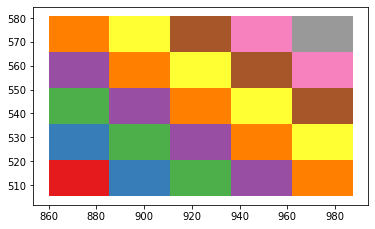

In [41]:
blocks(df, 'systematic', tiles_x=5, tiles_y=5, direction='anti').plot(column='grid_id', cmap='Set1')

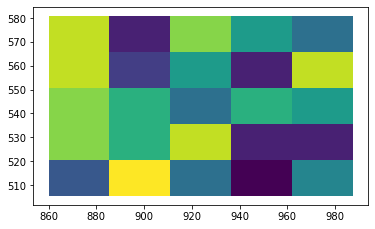

In [42]:
blocks(df, 'randomized', tiles_x=5, tiles_y=5, n_groups=12).plot(column='grid_id')

In [ ]:
class HBLOCK():
    
    def __init__(
        self,
        width=None,
        height=None,
        method=None
    ):
        if method == None:
            self.method = 'unique'
        
        self.width = width
        self.height = height
        self.method = method
    
    # define grid unique, contiguous, systematic, optimized random
    block_id = block_split(
        coordinates = XYs,
        width = 500,
        height = 500,
        method = 'unique'
    )
    
    # buffer grid or not?
    
    
    # split by grid_ids
    
    

In [12]:
cv = spacv.SLOO(XYs, radius=50)

scores = spacv.cross_val_score(model, X, y, cv, mean_squared_error)

In [14]:
np.sqrt(
    np.mean(scores)
)

0.3894339068089884